# Náš vlastný ResNet

V tomto notebooku je uvedená naša vlastná reziduálna neurónová sieť. Pomocou tejto siete sme sa snažili klasifikovať dataset obrázkov CIFAR-100, ktorý obsahuje 100 tried obrázkov.

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, optimizers, activations, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [2]:
if not tf.test.gpu_device_name():
    print("No GPU found")
else:
    print("GPU name: {}".format(tf.test.gpu_device_name()))

GPU name: /device:GPU:0


### Načítanie datasetu

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

# normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

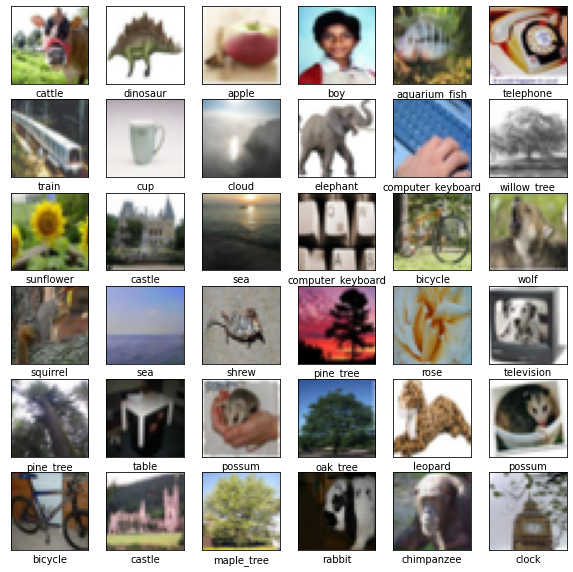

In [4]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    plt.xlabel(labels[train_labels[i][0]])
plt.show()

### Rozdelenie datasetu na trénovací a validačný

Našu trénovaciu množinu dát sme rozdelili na trénovaciu a validačnú v pomere 80:20

In [5]:
# split train data to train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=0)

### Nastavenie augmentácie nášho trénovacieho datasetu

Našu sieť sme najskôr trénovali bez augmentácie, avšak nemali sme dostatočne dobré výsledky. Z výsledkov nášho starého modelu sme tiež videli, že dochádza k tzv. overfittingu. Preto sme sa rozhodli pridať augmentáciu dát, ktorá dokáže riešiť problém overfittingu tým, že umelo vygeneruje nové obrázky, ktoré sú nejakým spôsobom upravené. V našom prípade sme zvolili horizontálne prevrátenie, rotáciu a posuny šírky a výšky.

In [6]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(x_train)

# ResNet

Našu reziduálnu sieť sme vytvárali na základe 

In [7]:
batch_size = 32
data_augmentation = True
num_classes = 100
subtract_pixel_mean = True
depth = 50

input_shape = train_images.shape[1:]

In [21]:
def resnet_layer(inputs, num_filters=16, kernel_size=6, strides=1, activation='relu',
                 batch_normalization=True, conv_first=True, regularization=False):
    
    conv = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

In [22]:
def resnet(input_shape, depth, num_classes=100):
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None,
                             regularization=True)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)

            x = layers.add([x, y])
            x = layers.Activation('relu')(x)
        num_filters *= 2
        
    x = layers.AveragePooling2D(pool_size=8)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    y = layers.Flatten()(x)
    
    outputs = layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [23]:
resnet_model = resnet(input_shape=input_shape, depth=depth)

In [24]:
resnet_model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [25]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_102 (Conv2D)            (None, 32, 32, 16)   1744        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_98 (BatchN  (None, 32, 32, 16)  64          ['conv2d_102[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_98 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_98[0]

 Normalization)                                                                                   
                                                                                                  
 activation_107 (Activation)    (None, 32, 32, 16)   0           ['batch_normalization_107[0][0]']
                                                                                                  
 conv2d_112 (Conv2D)            (None, 32, 32, 16)   9232        ['activation_107[0][0]']         
                                                                                                  
 batch_normalization_108 (Batch  (None, 32, 32, 16)  64          ['conv2d_112[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_52 (Add)                   (None, 32, 32, 16)   0           ['activation_106[0][0]',         
          

                                                                                                  
 conv2d_122 (Conv2D)            (None, 16, 16, 32)   36896       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_117 (Batch  (None, 16, 16, 32)  128         ['conv2d_122[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 16, 16, 32)   0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_123 (Conv2D)            (None, 16, 16, 32)   36896       ['activation_117[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_126 (Activation)    (None, 16, 16, 32)   0           ['add_61[0][0]']                 
                                                                                                  
 conv2d_132 (Conv2D)            (None, 16, 16, 32)   36896       ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_127 (Batch  (None, 16, 16, 32)  128         ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_127 (Activation)    (None, 16, 16, 32)   0           ['batch_normalization_127[0][0]']
                                                                                                  
 conv2d_13

 Normalization)                                                                                   
                                                                                                  
 add_66 (Add)                   (None, 8, 8, 64)     0           ['activation_134[0][0]',         
                                                                  'batch_normalization_136[0][0]']
                                                                                                  
 activation_136 (Activation)    (None, 8, 8, 64)     0           ['add_66[0][0]']                 
                                                                                                  
 conv2d_143 (Conv2D)            (None, 8, 8, 64)     147520      ['activation_136[0][0]']         
                                                                                                  
 batch_normalization_137 (Batch  (None, 8, 8, 64)    256         ['conv2d_143[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_146 (Batch  (None, 8, 8, 64)    256         ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_71 (Add)                   (None, 8, 8, 64)     0           ['activation_144[0][0]',         
                                                                  'batch_normalization_146[0][0]']
                                                                                                  
 activation_146 (Activation)    (None, 8, 8, 64)     0           ['add_71[0][0]']                 
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 1, 1, 64)    0           ['activation_146[0][0]']         
 oling2D) 

In [28]:
import time

start = time.time()

epochs = 100
batch_size = 64

# train with image augmentation
history2=resnet_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)])

end = time.time()
print("Time elapsed: ", end - start)

C:\Users\jakub\AppData\Local\Temp\ipykernel_2660\3547284515.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=resnet_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/100
625/625 [==============================] - 148s 231ms/step - loss: 4.3541 - accuracy: 0.0391 - val_loss: 4.1862 - val_accuracy: 0.0586
Epoch 2/100
625/625 [==============================] - 138s 221ms/step - loss: 3.9893 - accuracy: 0.0748 - val_loss: 4.8587 - val_accuracy: 0.0394
Epoch 3/100
625/625 [==============================] - 138s 221ms/step - loss: 3.7256 - accuracy: 0.1201 - val_loss: 3.6720 - val_accuracy: 0.1340
Epoch 4/100
625/625 [==============================] - 138s 220ms/step - loss: 3.4912 - accuracy: 0.1629 - val_loss: 3.4601 - val_accuracy: 0.1692
Epoch 5/100
625/625 [==============================] - 138s 220ms/step - loss: 3.3135 - accuracy: 0.1925 - val_loss: 3.2924 - val_accuracy: 0.2002
Epoch 6/100
625/625 [==============================] - 138s 220ms/step - loss: 3.1671 - accuracy: 0.2212 - val_loss: 3.4888 - val_accuracy: 0.1811
Epoch 7/100
625/625 [==============================] - 138s 221ms/step - loss: 3.0325 - accuracy: 0.2446 - val_loss: 3

In [29]:
y_pred = resnet_model.predict(test_images)
y_classes = [np.argmax(element) for element in y_pred]

print('Report: \n', classification_report(test_labels, y_classes))

Report: 
               precision    recall  f1-score   support

           0       0.90      0.64      0.75       100
           1       0.69      0.66      0.68       100
           2       0.53      0.33      0.41       100
           3       0.32      0.29      0.30       100
           4       0.39      0.35      0.37       100
           5       0.70      0.57      0.63       100
           6       0.61      0.65      0.63       100
           7       0.67      0.58      0.62       100
           8       0.65      0.83      0.73       100
           9       0.72      0.64      0.68       100
          10       0.48      0.40      0.43       100
          11       0.50      0.46      0.48       100
          12       0.49      0.63      0.55       100
          13       0.52      0.53      0.52       100
          14       0.40      0.44      0.42       100
          15       0.53      0.67      0.59       100
          16       0.68      0.54      0.60       100
          17     

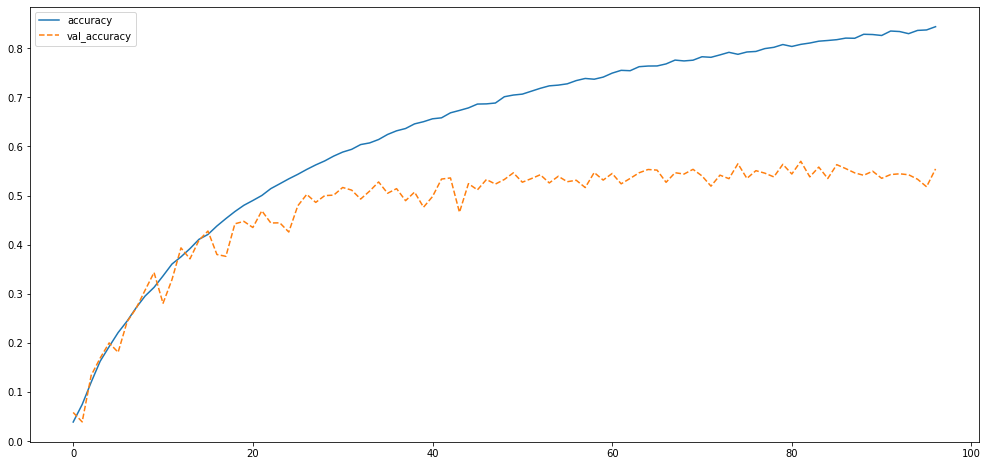

In [31]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.legend()

In [32]:
labels_names = []
for i in range(len(labels)):
    labels_names += [i]
    
reverse_mapping = dict(zip(labels_names, labels)) 

def mapper(value):
    return reverse_mapping[value]

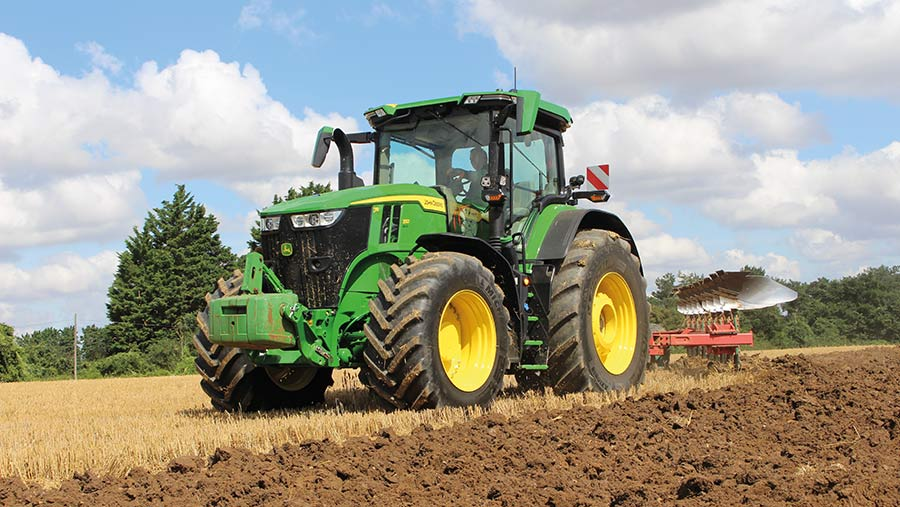

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

load_img('data/tractor.jpg')

In [46]:
# Pre-process image
image_1 = load_img('data/bicycle.jpg', target_size=(32, 32))
image_1 = img_to_array(image_1) 
image_1 = image_1 / 255.0
prediction_image_1 = np.array(image_1)
prediction_image_1 = np.expand_dims(image_1, axis=0)

In [47]:
# Get prediction
prediction_1 = resnet_model.predict(prediction_image_1)
value_1 = np.argmax(prediction_1)
name_1 = mapper(value_1)
print(f'Prediction is {name_1}.')

Prediction is bicycle.


In [52]:
image_2 = load_img('data/house.jpeg', target_size=(32, 32))
image_2 = img_to_array(image_2) 
image_2 = image_2 / 255.0
prediction_image_2 = np.array(image_2)
prediction_image_2 = np.expand_dims(image_2, axis=0)

In [53]:
prediction_2 = resnet_model.predict(prediction_image_2)
value_2 = np.argmax(prediction_2)
name_2 = mapper(value_2)
print(f'Prediction is {name_2}.')

Prediction is house.


In [64]:
image_3 = load_img('data/fox.jpg', target_size=(32, 32))
image_3 = img_to_array(image_3) 
image_3 = image_3 / 255.0
prediction_image_3 = np.array(image_3)
prediction_image_3 = np.expand_dims(image_3, axis=0)

In [65]:
prediction_3 = resnet_model.predict(prediction_image_3)
value_3 = np.argmax(prediction_3)
name_3 = mapper(value_3)
print(f'Prediction is {name_3}.')

Prediction is fox.
